In [2]:
!pip install --upgrade scikit-learn  

In [3]:
## if the requirements were not already satisfied you have to restart the kernel

In [4]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import os
owd = os.getcwd()
os.chdir('../src/features')
import preprocess as pp
os.chdir(owd)
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
import statsmodels.api as sm

In [5]:
conn = sqlite3.connect('../src/data/td_V2.db')
git_commits = pd.read_sql_query("SELECT * FROM GIT_COMMITS",conn)
szz_fault_inducing_commits = pd.read_sql_query("SELECT * FROM szz_fault_inducing_commits",conn)
refactoring_miner = pd.read_sql_query("SELECT * FROM refactoring_miner",conn)
refactoring_miner = refactoring_miner[refactoring_miner["COMMIT_HASH"].isin(git_commits["COMMIT_HASH"])]
git_commits_changes = pd.read_sql_query("SELECT * FROM GIT_COMMITS_CHANGES", conn)
git_commits_changes = git_commits_changes[git_commits_changes["COMMIT_HASH"].isin(refactoring_miner["COMMIT_HASH"])]

In [6]:
print(len(refactoring_miner), len(szz_fault_inducing_commits))
clean_df = pp.preprocess(git_commits, szz_fault_inducing_commits, refactoring_miner, git_commits_changes)
clean_df = clean_df[clean_df["FAULT_INDUCING_COMMIT_HASH"].isin(szz_fault_inducing_commits["FAULT_INDUCING_COMMIT_HASH"])]
clean_df

32334 52428


,REFACTORING_TYPE,FAULT_INDUCING_COMMIT_HASH,PROJECT_ID,COMMIT_MESSAGE,COMMITTER_DATE,BRANCHES,COMMITTER_ID,LINES_ADDED,LINES_REMOVED
0,Move Class,d522432b79044740831a132d8b92e7dab5477444,org.apache:bcel,Fix messed up package rename git-svn-id: http...,2016-06-07 17:28:43+00:00,{'master'},Benedikt Ritter,1506,1505
1,Extract Class,02f53e4fa6ec7fa339c8c9273183669d7f5928c9,org.apache:bcel,Gradually working towards restoring binary com...,2015-09-11 00:30:19+00:00,{'master'},Sebastian Bazley,3915,2105
2,Move Method,02f53e4fa6ec7fa339c8c9273183669d7f5928c9,org.apache:bcel,Gradually working towards restoring binary com...,2015-09-11 00:30:19+00:00,{'master'},Sebastian Bazley,3915,2105
3,Move Attribute,02f53e4fa6ec7fa339c8c9273183669d7f5928c9,org.apache:bcel,Gradually working towards restoring binary com...,2015-09-11 00:30:19+00:00,{'master'},Sebastian Bazley,3915,2105
4,Extract And Move Method,cfbd46ac5bfbb669776e9403375a581fc4d4e8bd,org.apache:bcel,Prepare for eventual privatisation of other ar...,2015-08-25 18:45:21+00:00,{'master'},Sebastian Bazley,177,29
...,...,...,...,...,...,...,...,...,...
3021,Move Class,0096b20883acf08c46389c8d232a49d8886074dc,org.apache:thrift,THRIFT-366. java: Lots of little warnings in j...,2009-03-13 00:28:06+00:00,{'master'},Bryan Duxbury,99,146
3022,Move Source Folder,249d7cb199b5c08e7a7a51189a733cc8fef12cf9,org.apache:thrift,THRIFT-166. java: Java tests should be in lib/...,2009-01-29 01:21:20+00:00,{'master'},Bryan Duxbury,52,65
3023,Move Class,afa80ea73d4cbf83afee807e5d9f9034fa177ade,org.apache:thrift,THRIFT-34 Java libraries should be namespaced ...,2009-01-15 23:47:51+00:00,{'master'},Bryan Duxbury,249,249
3024,Extract Method,d92ca7dcea105837e3e576f797501c19929eced5,org.apache:thrift,Prevent Java's TProtocolUtil.skip from overflo...,2008-03-18 19:32:00+00:00,{'master'},David Reiss,48,6


In [7]:
#git_commits['COMMITTER_DATE'] = pd.to_datetime(git_commits['COMMITTER_DATE'], errors='coerce')
first_commit = {}
for proj in git_commits.PROJECT_ID.unique().tolist():
    if proj in ['org.apache:batik','org.apache:cocoon','org.apache:felix','org.apache:santuario']:
        pass
    else:
        git_commits.loc[git_commits.PROJECT_ID == proj, 'COMMITTER_DATE'] = git_commits['COMMITTER_DATE'].apply(lambda x: str(x)[:-6])
    first_commit[proj] = pd.to_datetime(git_commits[git_commits.PROJECT_ID == proj]['COMMITTER_DATE'].min()).date()
    git_commits.loc[git_commits.PROJECT_ID == proj,'COMMITTER_DATE'] = pd.to_datetime(git_commits.loc[git_commits.PROJECT_ID == proj,'COMMITTER_DATE'], dayfirst=True).dt.date
    git_commits.loc[git_commits.PROJECT_ID == proj,'commit_day'] = git_commits.loc[git_commits.PROJECT_ID == proj,'COMMITTER_DATE'] - first_commit[proj]
git_commits['commit_day'] = git_commits['commit_day'].apply(lambda x: x.days)
    

In [8]:
def plot_monthly_commits(git_commits, project_id):
    data = git_commits[git_commits.PROJECT_ID == project_id][['COMMITTER_DATE']]
    plt.figure(figsize=(20,10))
    plt.hist(pd.to_datetime(data['COMMITTER_DATE']).dt.to_period('M').astype(str), bins=len(pd.to_datetime(data['COMMITTER_DATE']).dt.to_period('M').astype(str).unique()),
            color=('cornflowerblue'),edgecolor = 'silver')
    plt.xticks(pd.to_datetime(data['COMMITTER_DATE']).dt.to_period('M').astype(str).unique()[::5], rotation=70)
    plt.title('Monthly commits of: ' + project_id, size=18)
    plt.ylabel('Number of commits', size=14)
    plt.xlabel('Month', size=14)
    plt.show()


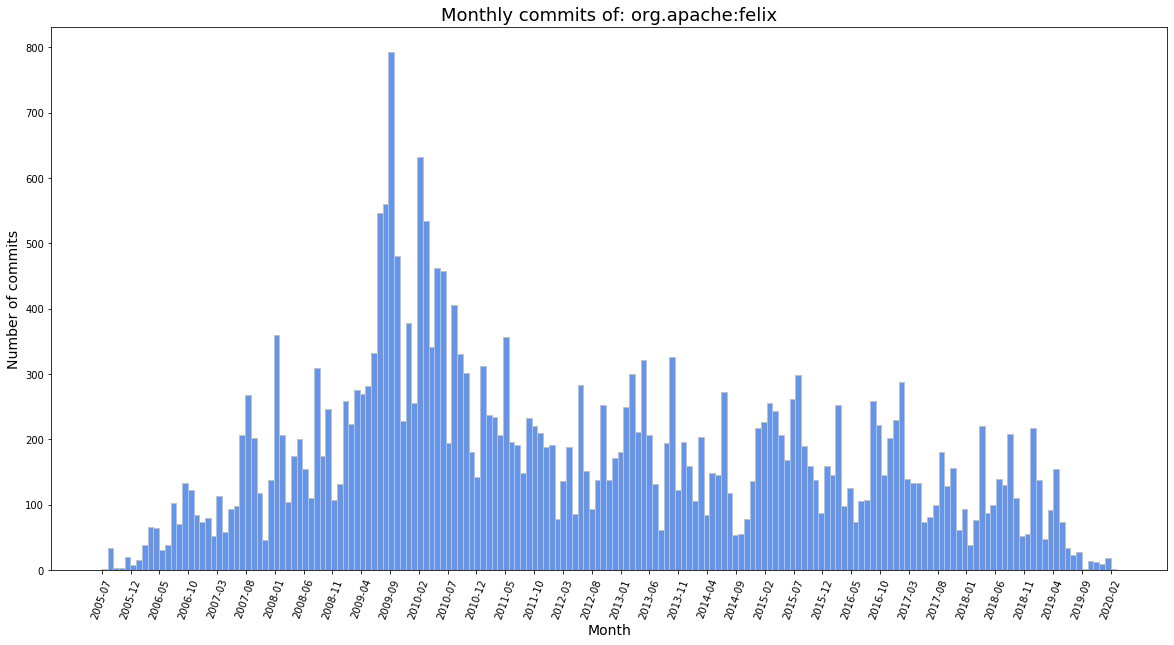

In [9]:
plot_monthly_commits(git_commits, 'org.apache:felix')


In [10]:
git_commits

,PROJECT_ID,COMMIT_HASH,COMMIT_MESSAGE,AUTHOR,AUTHOR_DATE,AUTHOR_TIMEZONE,COMMITTER,COMMITTER_DATE,COMMITTER_TIMEZONE,BRANCHES,IN_MAIN_BRANCH,MERGE,PARENTS,commit_day
0,org.apache:archiva,94fe3a7fc056638c90cbe4a6319c3cb658f395a5,create template structure git-svn-id: https:...,Brett Porter,2005-11-23 23:54:12+00:00,0,Brett Porter,2005-11-23,0,{'master'},True,False,[],0
1,org.apache:archiva,2b6be811c1d4f5e81339616208530d486608e42b,repository manager - root POM git-svn-id: ht...,Brett Porter,2005-11-28 03:15:35+00:00,0,Brett Porter,2005-11-28,0,{'master'},True,False,['94fe3a7fc056638c90cbe4a6319c3cb658f395a5'],5
2,org.apache:archiva,af0ddbcfc1e8c2528decbd458f42e16cbcae5051,update reports git-svn-id: https://svn.apach...,Brett Porter,2005-11-28 04:50:31+00:00,0,Brett Porter,2005-11-28,0,{'master'},True,False,['2b6be811c1d4f5e81339616208530d486608e42b'],5
3,org.apache:archiva,ea640e1803a8535ebfba2ade4ea9272b240067e8,move discovery to a new component PR: MRM-9 ...,Brett Porter,2005-11-29 01:34:22+00:00,0,Brett Porter,2005-11-29,0,{'master'},True,False,['af0ddbcfc1e8c2528decbd458f42e16cbcae5051'],6
4,org.apache:archiva,4b1232d671e7c0aa44927ce2d4574d8cb751497d,add discovery module PR: MRM-9 git-svn-id: h...,Brett Porter,2005-11-29 01:43:41+00:00,0,Brett Porter,2005-11-29,0,{'master'},True,False,['ea640e1803a8535ebfba2ade4ea9272b240067e8'],6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153989,org.apache:santuario,3bbe9d92b996fed10440ba772e1be711c183f781,Minor optimisation\n\ngit-svn-id: https://svn....,Colm O hEigeartaigh,2019-06-25T13:59:59Z,0,Colm O hEigeartaigh,2019-06-25,0,['trunk'],True,False,['0dd1dd24374d5fd24967cb964dbf785dc8113a41'],6479
153990,org.apache:santuario,0114371d12701f4358746d6e39d54efc48a2a332,Minor improvement to XMLUtils\n\ngit-svn-id: h...,Colm O hEigeartaigh,2019-07-11T14:50:10Z,0,Colm O hEigeartaigh,2019-07-11,0,['trunk'],True,False,['3bbe9d92b996fed10440ba772e1be711c183f781'],6495
153991,org.apache:santuario,c05467b72c02227ce64ca7000a670b6f1eb5bdf1,Updating some dependencies\n\ngit-svn-id: http...,Colm O hEigeartaigh,2019-07-12T08:12:52Z,0,Colm O hEigeartaigh,2019-07-12,0,['trunk'],True,False,['0114371d12701f4358746d6e39d54efc48a2a332'],6496
153992,org.apache:santuario,5aa25ac67d4e4efae605220f84935145827247e9,Removing XMLSignatureInput fallback\n\ngit-svn...,Colm O hEigeartaigh,2019-07-12T11:00:28Z,0,Colm O hEigeartaigh,2019-07-12,0,['trunk'],True,False,['c05467b72c02227ce64ca7000a670b6f1eb5bdf1'],6496


In [11]:
(clean_df["FAULT_INDUCING_COMMIT_HASH"] == "30cff66e5efe6b99b7e7a2293061f0eea0def02f").sum()

12

In [12]:
szz_fault_inducing_commits[szz_fault_inducing_commits.FAULT_INDUCING_COMMIT_HASH == 'fc186f50392bf8c804b1d314971c92efa5f52fc3']

,PROJECT_ID,FAULT_FIXING_COMMIT_HASH,FAULT_INDUCING_COMMIT_HASH
4095,org.apache:cayenne,20616104fe25faaf014b23180fb8a40a6d93cbad,fc186f50392bf8c804b1d314971c92efa5f52fc3
4096,org.apache:cayenne,770a960d251b42dc323a87b2cdf4cef844777a31,fc186f50392bf8c804b1d314971c92efa5f52fc3
4097,org.apache:cayenne,6044e64c46033377d72c5cf1b3342b376df0cee7,fc186f50392bf8c804b1d314971c92efa5f52fc3
4101,org.apache:cayenne,5f364c585b9fc39e02d271747f30447c62030ab2,fc186f50392bf8c804b1d314971c92efa5f52fc3
4102,org.apache:cayenne,fa5f7734aa45a448463d44ec7474326f978710c1,fc186f50392bf8c804b1d314971c92efa5f52fc3
...,...,...,...
7039,org.apache:cayenne,9e6c27ba798839f5dd3e26f36e89b8bb8bc297d7,fc186f50392bf8c804b1d314971c92efa5f52fc3
7046,org.apache:cayenne,9b91f6d2a150d83918acf8999442f2bb120f2ce6,fc186f50392bf8c804b1d314971c92efa5f52fc3
7050,org.apache:cayenne,90c19b0c18614346eb110265da2780caaa84dc09,fc186f50392bf8c804b1d314971c92efa5f52fc3
7068,org.apache:cayenne,fa4bddd4c1f6081f4d4f604f5c19826416387244,fc186f50392bf8c804b1d314971c92efa5f52fc3


In [13]:
refactor_commits = refactoring_miner[["COMMIT_HASH", "REFACTORING_TYPE"]].merge(git_commits_changes[["COMMIT_HASH", "DATE", "COMMITTER_ID", "LINES_ADDED", "LINES_REMOVED"]], on = "COMMIT_HASH")
refactor_commits["LINES_ADDED"] = refactor_commits["LINES_ADDED"].astype(int)
refactor_commits["LINES_REMOVED"] = refactor_commits["LINES_REMOVED"].astype(int)


In [14]:
refactor_commits = refactor_commits.groupby(['COMMIT_HASH', 'COMMITTER_ID', 'REFACTORING_TYPE']).sum().reset_index()
refactor_commits = refactor_commits.merge(git_commits[['COMMIT_HASH','commit_day']])


In [15]:
refactor_commits

,COMMIT_HASH,COMMITTER_ID,REFACTORING_TYPE,LINES_ADDED,LINES_REMOVED,commit_day
0,0010369ccf1cdf25e10ed2fd3a080edaf374d0ed,Oleg Kalnichevski,Move Class,64,13,642
1,0010369ccf1cdf25e10ed2fd3a080edaf374d0ed,Oleg Kalnichevski,Rename Package,64,13,642
2,00131775cf82db598a0cda06bb36c67cb3602a81,David Leangen,Rename Method,172,44,4431
3,001db0530d1ad937a0d6ea6dded9b70b2cbe2cff,Marcel Offermans,Extract And Move Method,457,94,1603
4,00354024c64400dfaba80873e55fa365d45b1f9f,Gary Gregory,Rename Parameter,36,12,6267
...,...,...,...,...,...,...
10680,ffe13cfcca913a3eff9cec27f0a3ad2b6dcedcc8,Thomas Neidhart,Pull Up Method,4776,2368,5334
10681,ffe13cfcca913a3eff9cec27f0a3ad2b6dcedcc8,Thomas Neidhart,Rename Variable,597,296,5334
10682,ffe5f635c89468c0517e3aaafa41e15137e7eb57,Simone Tripodi,Rename Method,5,46,3707
10683,fff4bdfef9d8f6267177f6dba38691ec9bd7bcb0,Oleg Kalnichevski,Rename Class,19,20,3948


In [16]:
git_commits_changes

,PROJECT_ID,FILE,COMMIT_HASH,DATE,COMMITTER_ID,LINES_ADDED,LINES_REMOVED,NOTE
7569,org.apache:archiva,pom.xml,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....
7570,org.apache:archiva,RepositoryArtifactIndex.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....
7571,org.apache:archiva,RepositoryArtifactIndexFactory.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....
7572,org.apache:archiva,RepositoryIndexException.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....
7573,org.apache:archiva,RepositoryIndexSearchException.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....
...,...,...,...,...,...,...,...,...
1142562,org.apache:santuario,.settings/org.eclipse.jdt.core.prefs,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,1,0,SANTUARIO-487 - Allow users to set a SecurityE...
1142563,org.apache:santuario,src/main/java/org/apache/xml/security/stax/ext...,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,27,7,SANTUARIO-487 - Allow users to set a SecurityE...
1142564,org.apache:santuario,src/main/java/org/apache/xml/security/stax/imp...,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,14,4,SANTUARIO-487 - Allow users to set a SecurityE...
1142565,org.apache:santuario,src/main/java/org/apache/xml/security/stax/imp...,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,3,2,SANTUARIO-487 - Allow users to set a SecurityE...


In [17]:
git_commits_changes.PROJECT_ID.value_counts()

org.apache:cocoon                18287
org.apache:felix                 17757
org.apache:batik                 12292
org.apache:httpcore              10978
org.apache:httpclient             9343
org.apache:archiva                8965
org.apache:zookeeper              5586
org.apache:collections            4859
org.apache:vfs                    3660
org.apache:hive                   3636
org.apache:commons-jelly          3100
org.apache:bcel                   3045
org.apache:santuario              3041
org.apache:configuration          2998
org.apache:cayenne                2900
org.apache:commons-jexl           1851
org.apache:digester               1623
org.apache:jxpath                 1212
org.apache:dbcp                    939
org.apache:beanutils               909
org.apache:codec                   862
org.apache:ognl                    841
org.apache:commons-io              670
org.apache:net                     604
org.apache:commons-cli             471
org.apache:validator     

In [18]:
git_commits['num_commit'] = 0
for proj in git_commits.PROJECT_ID.unique().tolist():
    max_comm = len(git_commits[git_commits.PROJECT_ID == proj])
    git_commits.loc[git_commits.PROJECT_ID == proj, 'num_commit'] = list(range(max_comm))

In [19]:
#git_commits_changes.drop(columns='COMMITTER_DATE', errors='ignore', inplace=True)
#git_commits_changes = git_commits_changes.merge(git_commits[['COMMIT_HASH','COMMITTER_DATE']], on = 'COMMIT_HASH')

git_commits_changes = git_commits_changes.merge(git_commits[['COMMIT_HASH','num_commit']], on = 'COMMIT_HASH')


In [20]:
git_commits_changes

,PROJECT_ID,FILE,COMMIT_HASH,DATE,COMMITTER_ID,LINES_ADDED,LINES_REMOVED,NOTE,num_commit
0,org.apache:archiva,pom.xml,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....,1124
1,org.apache:archiva,RepositoryArtifactIndex.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....,1124
2,org.apache:archiva,RepositoryArtifactIndexFactory.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....,1124
3,org.apache:archiva,RepositoryIndexException.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....,1124
4,org.apache:archiva,RepositoryIndexSearchException.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....,1124
...,...,...,...,...,...,...,...,...,...
121640,org.apache:santuario,.settings/org.eclipse.jdt.core.prefs,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,1,0,SANTUARIO-487 - Allow users to set a SecurityE...,5611
121641,org.apache:santuario,src/main/java/org/apache/xml/security/stax/ext...,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,27,7,SANTUARIO-487 - Allow users to set a SecurityE...,5611
121642,org.apache:santuario,src/main/java/org/apache/xml/security/stax/imp...,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,14,4,SANTUARIO-487 - Allow users to set a SecurityE...,5611
121643,org.apache:santuario,src/main/java/org/apache/xml/security/stax/imp...,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,3,2,SANTUARIO-487 - Allow users to set a SecurityE...,5611


In [ ]:
# Execution of the code below is too slow
# for that reason a simple version of dynamic programming will be implemented
# will consist on saving in an array the number of commits realized in the last week / preferred period
# in that way for each day the value will only be computed once

In [ ]:
# 1 group by day the num of lines added
# 2 create one array per project with one position per day
# 3 fill out the arrays using loc and a similar version of the code below
# 4 map the values of the arrays to the dataframe

In [23]:
git_commits_changes['lines_added_last_commits'] = 0
git_commits_changes['LINES_ADDED'] = git_commits_changes['LINES_ADDED'].astype(int)
#git_commits_changes['last_week'] = pd.to_datetime(git_commits_changes['COMMITTER_DATE'], dayfirst=True).dt.date - pd.Timedelta('7 days')
#git_commits_changes['last_week'] = git_commits_changes['last_week'].astype(str)
#git_commits_changes['COMMITTER_DATE'] = git_commits_changes['COMMITTER_DATE'].astype(str)
#git_commits_changes['COMMITTER_DATE'] = pd.to_datetime(git_commits_changes['COMMITTER_DATE']).dt.date
for proj in git_commits_changes.PROJECT_ID.unique().tolist():
    print(proj)
    #git_commits_changes.loc[git_commits_changes.PROJECT_ID == proj, 'lines_added_last_week'] = git_commits_changes[git_commits_changes.PROJECT_ID == proj].apply(lambda x: \
        #git_commits_changes[(git_commits_changes.COMMITTER_DATE < x['COMMITTER_DATE']) & (git_commits_changes.COMMITTER_DATE >= x.last_week) & (git_commits_changes.PROJECT_ID == proj)]['LINES_ADDED'].sum(), axis=1)
        
    git_commits_changes.loc[git_commits_changes.PROJECT_ID == proj, 'lines_added_last_commits'] = git_commits_changes[git_commits_changes.PROJECT_ID == proj].apply(lambda x: \
        git_commits_changes[(git_commits_changes.num_commit < x.num_commit) & (git_commits_changes.num_commit >= x.num_commit - 7) & (git_commits_changes.PROJECT_ID == proj)]['LINES_ADDED'].sum(), axis=1)
                
        

org.apache:archiva
org.apache:bcel
org.apache:beanutils


KeyboardInterrupt: 

In [102]:
print(len(git_commits_changes))
git_commits_changes[git_commits_changes.lines_added_last_commits.isnull()]

121645


,PROJECT_ID,FILE,COMMIT_HASH,DATE,COMMITTER_ID,LINES_ADDED,LINES_REMOVED,NOTE,lines_added_last_week,COMMITTER_DATE,last_week,num_commit,lines_added_last_commits
0,org.apache:archiva,pom.xml,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....,0,2007-03-22,2007-03-15,1124,NaN
1,org.apache:archiva,RepositoryArtifactIndex.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....,0,2007-03-22,2007-03-15,1124,NaN
2,org.apache:archiva,RepositoryArtifactIndexFactory.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....,0,2007-03-22,2007-03-15,1124,NaN
3,org.apache:archiva,RepositoryIndexException.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....,0,2007-03-22,2007-03-15,1124,NaN
4,org.apache:archiva,RepositoryIndexSearchException.java,0314ca95cbd0580114688cb26179e47e7edb19a7,2007-03-22 21:12:12+00:00,Joakim Erdfelt,0,0,More directory moves git-svn-id: https://svn....,0,2007-03-22,2007-03-15,1124,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121640,org.apache:santuario,.settings/org.eclipse.jdt.core.prefs,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,1,0,SANTUARIO-487 - Allow users to set a SecurityE...,0,2018-05-15,2018-05-08,5611,NaN
121641,org.apache:santuario,src/main/java/org/apache/xml/security/stax/ext...,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,27,7,SANTUARIO-487 - Allow users to set a SecurityE...,0,2018-05-15,2018-05-08,5611,NaN
121642,org.apache:santuario,src/main/java/org/apache/xml/security/stax/imp...,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,14,4,SANTUARIO-487 - Allow users to set a SecurityE...,0,2018-05-15,2018-05-08,5611,NaN
121643,org.apache:santuario,src/main/java/org/apache/xml/security/stax/imp...,b91e5b0cf9c8fc7f26e831d402223220ce4dc847,2018-05-15 13:03:07+00:00,Colm O hEigeartaigh,3,2,SANTUARIO-487 - Allow users to set a SecurityE...,0,2018-05-15,2018-05-08,5611,NaN


In [74]:
8+4


12

In [36]:
git_commits_changes[git_commits_changes.PROJECT_ID == proj].COMMITTER_DATE

0       2007-03-22 21:12:12
1       2007-03-22 21:12:12
2       2007-03-22 21:12:12
3       2007-03-22 21:12:12
4       2007-03-22 21:12:12
               ...         
8960    2012-02-24 21:18:34
8961    2012-02-24 21:18:34
8962    2012-02-24 21:18:34
8963    2012-02-24 21:18:34
8964    2012-02-24 21:18:34
Name: COMMITTER_DATE, Length: 8965, dtype: object

In [13]:
inducing_ones = refactor_commits[refactor_commits["COMMIT_HASH"].isin(clean_df["FAULT_INDUCING_COMMIT_HASH"])]
refactor_commits["LABEL"] = np.where(refactor_commits["COMMIT_HASH"].isin(clean_df["FAULT_INDUCING_COMMIT_HASH"]), 1, 0)


In [ ]:
y = refactor_commits["LABEL"]
X = refactor_commits.drop(columns = ["COMMIT_HASH","LABEL", "COMMITTER_ID"])
X["REFACTORING_TYPE"] = X["REFACTORING_TYPE"].astype("category").cat.codes

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = svm.SVC(kernel = 'rbf')
clf.fit(X_train, y_train)
predicts = clf.predict(X_test)
confusion_matrix(y_test, predicts)

array([[2509,    2],
       [1016,    0]])

In [15]:
y_train = pd.Series(y_train).replace(1,0.95).replace(0,0.05)
y_train = np.asarray(y_train).astype(float)
model = sm.GLM(y_train,X_train, family = sm.families.Binomial())
res = model.fit()
res = res.predict(X_test)
confusion_matrix(y_test, res > 0.5)

array([[2505,    6],
       [1014,    2]])